In [28]:
import xml.etree.ElementTree as ET
import csv
from lxml import etree

# This Code uses the GML file to extract the depth data and the polygons that describe the surfaces. Then it tries to interpolate with the surfaces set to 0

In [39]:
def extract_gml_data(gml_file, csv_file):
    tree = ET.parse(gml_file)
    root = tree.getroot()
    
    ns = {
        'gml': 'http://www.opengis.net/gml/3.2',
        'app': 'http://skjema.geonorge.no/SOSI/produktspesifikasjon/Dybdedata/20201001'
    }
    
    data = []
    
    for feature in root.findall('.//gml:featureMember/app:*', ns):
        pos_elem = feature.find('.//app:posisjon/gml:Point/gml:pos', ns)
        dybde_elem = feature.find('.//app:dybde', ns)
        dybdetype_elem = feature.find('.//app:dybdetype', ns)
        
        if pos_elem is not None and dybde_elem is not None and dybdetype_elem is not None:
            x, y = pos_elem.text.strip().split()
            dybde = dybde_elem.text.strip()
            dybdetype = dybdetype_elem.text.strip()
            data.append([x, y, dybde, dybdetype])
    
    with open(csv_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['X', 'Y', 'Dybde', 'Dybdetype'])
        writer.writerows(data)

def extract_polygons_from_gml(gml_file, output_csv):
    # Parse the GML file
    tree = etree.parse(gml_file)
    root = tree.getroot()

    # Namespace dictionary
    namespaces = {
        'gml': 'http://www.opengis.net/gml/3.2',
        'app': 'http://skjema.geonorge.no/SOSI/produktspesifikasjon/Dybdedata/20201001'
    }

    # Open the CSV file to write the extracted data
    with open(output_csv, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['ID', 'Coordinates'])  # Write the header

        # Iterate over all feature members in the GML file
        for feature_member in root.findall('.//gml:featureMember', namespaces):
            
            landareal = feature_member.find('.//app:Landareal', namespaces)
            if landareal is not None:
                # Extract the ID of the Landareal feature
                feature_id = landareal.get('{http://www.opengis.net/gml/3.2}id')

                # Extract the coordinates from the Surface element (not Polygon)
                surface = landareal.find('.//gml:Surface', namespaces)
                if surface is not None:
                    patches = surface.find('.//gml:patches', namespaces)
                    if patches is not None:
                        polygon_patch = patches.find('.//gml:PolygonPatch', namespaces)
                        if polygon_patch is not None:
                            exterior = polygon_patch.find('.//gml:exterior', namespaces)
                            if exterior is not None:
                                linear_ring = exterior.find('.//gml:LinearRing', namespaces)
                                if linear_ring is not None:
                                    pos_list = linear_ring.find('.//gml:posList', namespaces)
                                    if pos_list is not None:
                                        coordinates = pos_list.text.strip()  # Get the coordinates as a string
                                        writer.writerow([feature_id, coordinates])


In [40]:
extract_gml_data('workingg.gml', 'output.csv')

gml_file = 'workingg.gml'  # Path to your GML file
output_csv = 'polygons.csv'  # Path to the output CSV file
extract_polygons_from_gml(gml_file, output_csv)

In [8]:
%pip install seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from shapely.geometry import Polygon, Point

In [49]:
# Reading the polygons.csv file
csv.field_size_limit(1000000)
with open('polygons.csv', newline='') as polygons_file:
    reader = csv.DictReader(polygons_file)
    coordinates = []
    
    for row in reader:
        # Splitting the coordinates by space and adding to the list
        coords = row['Coordinates'].split(' ')
        for i in range(0, len(coords), 2):
            x = coords[i]
            y = coords[i + 1]
            coordinates.append([x, y, 0, 0])  # Adding Dybde and Dybdetype as 0

# Writing the data to output.csv
with open('output.csv', mode='a', newline='') as output_file:
    writer = csv.writer(output_file)
    for coord in coordinates:
        writer.writerow(coord)

In [50]:
def create_2d_depthmap(csv_file):
    # Load CSV data
    df = pd.read_csv(csv_file)
    
    # Convert columns to numeric
    df['X'] = pd.to_numeric(df['X'])
    df['Y'] = pd.to_numeric(df['Y'])
    df['Dybde'] = pd.to_numeric(df['Dybde'])
    
    # Create a grid for interpolation
    grid_x, grid_y = np.mgrid[df['X'].min():df['X'].max():100j, df['Y'].min():df['Y'].max():100j]
    grid_z = griddata((df['X'], df['Y']), df['Dybde'], (grid_x, grid_y), method='cubic')
    
    # Create 2D depth map
    plt.figure(figsize=(12, 8))
    plt.imshow(grid_z.T, extent=(df['X'].min(), df['X'].max(), df['Y'].min(), df['Y'].max()), origin='lower', cmap='Blues_r')
    plt.colorbar(label='Depth (m)')
    plt.title('Seafloor Depth Map')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()

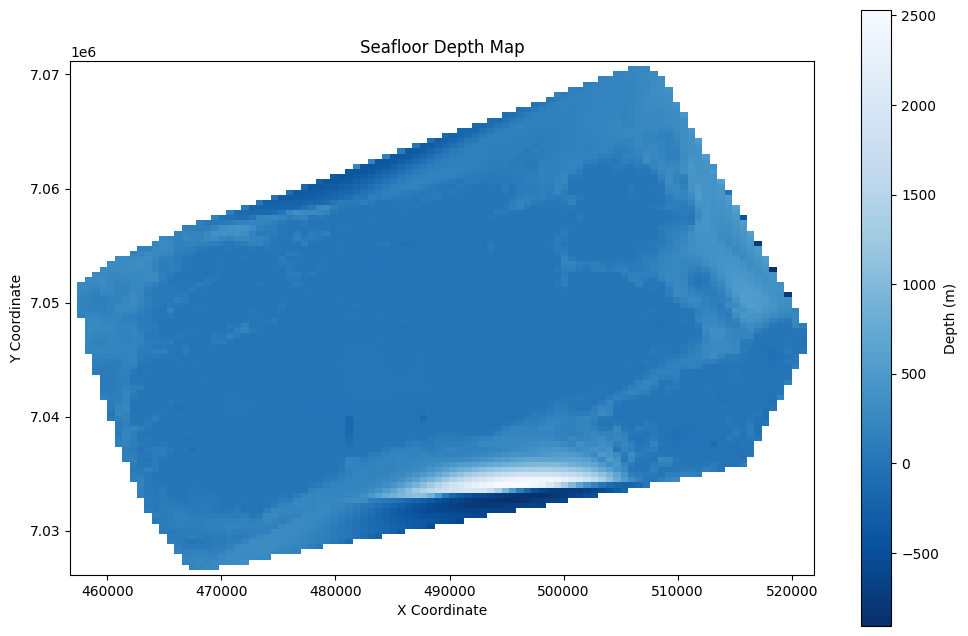

In [51]:
polygons_csv = 'polygons.csv'  # Path to your CSV file containing polygon data
output_csv = 'output.csv'  # Path to your output CSV with X, Y, Dybde values
create_2d_depthmap(output_csv)

In [53]:
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
import plotly.graph_objects as go

def create_3d_depthmap(csv_file):
    # Load CSV data
    df = pd.read_csv(csv_file)
    
    # Convert columns to numeric
    df['X'] = pd.to_numeric(df['X'])
    df['Y'] = pd.to_numeric(df['Y'])
    df['Dybde'] = pd.to_numeric(-df['Dybde'])
    
    # Create a grid for interpolation
    grid_x, grid_y = np.mgrid[df['X'].min():df['X'].max():100j, df['Y'].min():df['Y'].max():100j]
    grid_z = griddata((df['X'], df['Y']), df['Dybde'], (grid_x, grid_y), method='cubic')
    
    # Create 3D surface plot
    fig = go.Figure(data=[go.Surface(z=grid_z.T, x=grid_x, y=grid_y, colorscale='Blues', colorbar=dict(title='Depth (m)'))])

    # Update layout for interactive plot
    fig.update_layout(
        title='Seafloor Depth Map',
        scene=dict(
            xaxis_title='X Coordinate',
            yaxis_title='Y Coordinate',
            zaxis_title='Depth (m)',
        ),
        autosize=True
    )

    # Show the interactive plot
    fig.show()

# Example usage
create_3d_depthmap('output.csv')
